<a href="https://colab.research.google.com/github/jakeoung/ShapeFromProjections/blob/master/ctdr_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install shapefromprojections package
!git clone https://github.com/jakeoung/shapefromprojections
%cd shapefromprojections
!pip install -e .

fatal: destination path 'shapefromprojections' already exists and is not an empty directory.
/content/shapefromprojections
Obtaining file:///content/shapefromprojections
  Found existing installation: ctdrm 0.9.0
    Can't uninstall 'ctdrm'. No files were found to uninstall.
  Running setup.py develop for ctdrm


In [2]:
# install CUDA kernels
%cd ctdr/cuda
!python build.py build_ext --inplace
%cd ../../run

/content/shapefromprojections/ctdr/cuda
running build_ext
/usr/local/lib/python3.6/dist-packages/torch/utils/cpp_extension.py:335: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
copying build/lib.linux-x86_64-3.6/cuda_diff_fp.cpython-36m-x86_64-linux-gnu.so -> 
/content/shapefromprojections/run


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import h5py
import time

import ctdr
from parse_args import args, update_args
from ctdr.model.vanilla import Model
from ctdr.dataset import init_mesh
from ctdr.utils import util_mesh
from ctdr import optimize
import subprocess

#torch.backends.cudnn.benchmark=True

#------------------------------------------------
# load data
#------------------------------------------------
from ctdr.dataset import dataset

args.data='2starA'
# args.niter=3000
update_args(args)

if args.data.find("tomop") > 0:
    args.nmaterials = int(args.data[-3:-1])+1

ds = dataset.SinoDataset(args.ddata, args.nmaterials, args.eta)
width_physical = ds.proj_geom['DetectorSpacingX']*ds.proj_geom['DetectorColCount']
height_physical = ds.proj_geom['DetectorSpacingY']*ds.proj_geom['DetectorRowCount']
physical_unit = min(width_physical, height_physical)

finit_obj = args.ddata+'/init.obj'

# if os.path.exists(finit_obj) == False:
if True:
    init_mesh.save_init_mesh(finit_obj, args.data, args.nmaterials, physical_unit, args.subdiv)
else:
    print(f"Use existing init file {finit_obj}")

use_center_param = False
mus = np.arange(ds.nmaterials) / (ds.nmaterials-1)

print(finit_obj)
# refine
model = Model(finit_obj, ds.proj_geom, args.nmaterials,
              mus, args.nmu0, wlap=args.wlap, wflat=args.wflat).cuda()

Namespace(b=0, cuda=-1, data='2starA', dataroot='../data/', ddata='../data/2starA/', dresult='../result/2starA/ours_-b_0_-eta_0_-lr_0.01_-niter_500_-niter0_0_-nmu0_1_-subdiv_4_-wedge_2.0_-wflat_0.01_-wlap_10.0_/', eta=0, lr=0.01, niter=500, niter0=0, nmaterials=2, nmu0=1, resroot='../result', subdiv=4, verbose=1, wedge=2.0, wflat=0.01, wlap=10.0)


In [50]:
def get_params(model, exclude_mus=False):
    return model.parameters()

def run_simple(model, ds, niter, args):
    print("@ model.mus", model.mus)
    
    params = get_params(model)
    
    opt = torch.optim.Adam(params, args.lr, betas=(0.9, 0.99))
    
    idx_angles_full = torch.LongTensor(np.arange(ds.nangles))
    p_full = ds.p.cuda()
    ds_loader = [ [ idx_angles_full, p_full ]  ]

    mask_bg = ds.p < 1e-5
    mask_bg = mask_bg.cuda()

    print(f"@ statistics of mesh: {model.vertices.shape[0]}, {model.faces.shape[0]}\n")

    #mask_bg = 1
    ledge = 0
    llap = 0.
    lflat = 0.

    for epoch in range(niter):
        # if epoch % 20 == 0 or epoch == niter-1:
        for idx_angles, p_batch in ds_loader:
            displace_prev = model.displace.data.clone()
            if args.b > 0:
                p_batch = p_batch.cuda()

            opt.zero_grad()
            
            phat, mask_valid, edge_loss, lap_loss, flat_loss = model(idx_angles, args.wedge) # full angles
            # phat[~mask_valid] = 0.0
            # mask_valid = mask_valid + mask_bg
            
            # l2 loss
            data_loss = (p_batch - phat)[mask_valid].pow(2).mean()

            loss = data_loss + args.wedge * edge_loss + args.wlap * lap_loss + args.wflat * flat_loss
            
                        
            loss.backward()
            opt.step()
            
            loss_now = loss.item()
            model.mus.data.clamp_(min=0.0)

        if epoch % 20 == 0 or epoch == niter-1:            
            if args.wedge > 0.:
                ledge = edge_loss.item()
                
            if args.wlap > 0.:
                llap = lap_loss.item()
            
            if args.wflat > 0.:
                lflat = flat_loss.item()

            print(f'~ {epoch:03d} l2_loss: {data_loss.item():.8f} edge: {ledge:.6f} lap: {llap:.6f} flat: {lflat:.6f} mus: {str(model.mus.cpu().detach().numpy())}')

    return phat         

In [51]:
args.wlap = 10.0
args.wflat = 0.0
args.wedge = 0.0
phat = run_simple(model, ds, 200, args)

@ model.mus Parameter containing:
tensor([0.0000, 1.0044], device='cuda:0', requires_grad=True)
@ statistics of mesh: 2562, 5120

~ 000 l2_loss: 0.00003120 edge: 0.000000 lap: 0.000024 flat: 0.000000 mus: [0.00249994 1.0069079 ]
ndead nneg phat.min and max_v: 1 1 -4.09, 1.63
~ 020 l2_loss: 0.00002678 edge: 0.000000 lap: 0.000021 flat: 0.000000 mus: [0.        1.0052758]
~ 040 l2_loss: 0.00002536 edge: 0.000000 lap: 0.000020 flat: 0.000000 mus: [4.8184800e-05 1.0054477e+00]
~ 060 l2_loss: 0.00002496 edge: 0.000000 lap: 0.000020 flat: 0.000000 mus: [2.2567627e-05 1.0054525e+00]
ndead nneg phat.min and max_v: 1 1 -3.56, 1.63
ndead nneg phat.min and max_v: 1 1 -3.70, 1.63
~ 080 l2_loss: 0.00002438 edge: 0.000000 lap: 0.000020 flat: 0.000000 mus: [0.        1.0053829]
ndead nneg phat.min and max_v: 1 1 -4.02, 1.63
~ 100 l2_loss: 0.00002392 edge: 0.000000 lap: 0.000020 flat: 0.000000 mus: [3.0671276e-06 1.0054214e+00]
~ 120 l2_loss: 0.00002360 edge: 0.000000 lap: 0.000019 flat: 0.000000 mus:

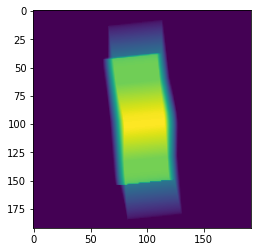

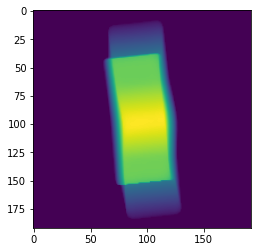

In [55]:
# Show the projection image for data and our estimation
plt.imshow(ds.p[1,:,:]); plt.show()
plt.imshow(phat.detach().cpu().numpy()[1,:,:]); plt.show()

In [47]:
# Optional: save the results
# vv = model.vertices.cpu()+model.displace.detach().cpu()
# ff = model.faces.cpu()

# labels_v, labels_f = model.labels_v_np, model.labels.cpu().numpy()
# # util_vis.save_vf_as_img_labels(args.dresult+f'{epoch:04d}_render.png', vv, ff, labels_v, labels_f)
# util_vis.save_sino_as_img(args.dresult+f'{epoch:04d}_sino.png', phat.detach().cpu().numpy())
# util_mesh.save_mesh(args.dresult+f'{epoch:04d}.obj', vv.numpy(), ff.numpy(), labels_v, labels_f)

# util_mesh.save_mesh(args.dresult+'mesh.obj', vv.numpy(), ff.numpy(), labels_v, labels_f)
# util_vis.save_sino_as_img(args.dresult+f'{epoch:04d}_data.png', ds.p.cuda())